In [1]:
## Imports
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import quad
from scipy.optimize import minimize
import control as ctrl
from scipy.linalg import solve
import scipy.linalg
from scipy.signal import place_poles
from scipy import stats
import pandas as pd

import seaborn as sns
from scipy.signal import cont2discrete
from matplotlib.ticker import FuncFormatter


/Users/aureliensoenen/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


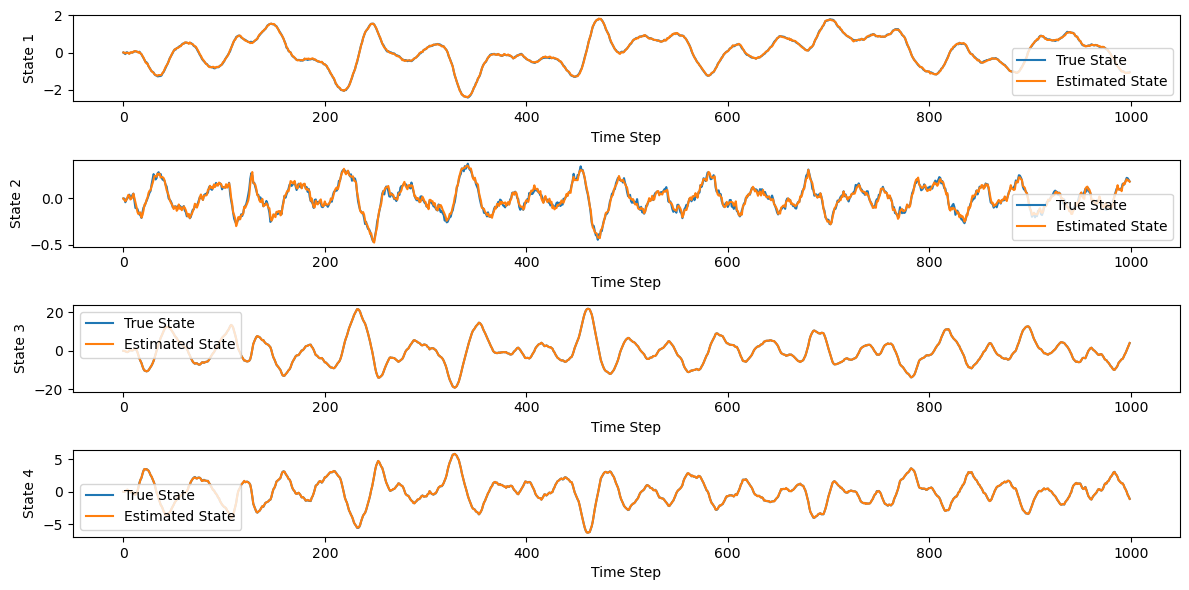

In [4]:
import numpy as np


# Define system matrices
A_c = np.array([
    [0, 0, 1, 0], 
    [0, 0, 0, 1], 
    [0, -69.4, 0, 0], 
    [0, 150, 0, 0]
])

B_c = np.array([[0], [0], [273], [-130]])

# Parameters
n = A_c.shape[1]
m = B_c.shape[1]

Ts = 0.01  # Sampling time
# Discretize the system
C = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])  # Output matrix

D = np.array([[0],[0],[0],[0]])
A, B, _,_,_ = cont2discrete((A_c, B_c, C, D), Ts, method='zoh')

# Kalman filter parameters
Q = np.eye(n) * 0.03**2  # Process noise covariance
R = np.eye(n) * 0.03**2  # Measurement noise covariance
P = np.eye(n)  # Initial estimation covariance
x_hat = np.zeros(n)  # Initial state estimate

# Simulation parameters
T = 1000
x_true = np.zeros((n, T))
x_est = np.zeros((n, T))
u = np.zeros((m, T))

# Set random seed for reproducibility
np.random.seed(50)

# Simulate the system
for t in range(T-1):
    u[:, t] = - K_itae_theory @ x_hat  # Use state estimate for control input
    noise = np.random.randn(n) * 0.03
    x_true[:, t+1] = A @ x_true[:, t] + B @ u[:, t] + noise

    # Prediction step
    x_pred = A @ x_hat + B @ u[:, t]
    P_pred = A @ P @ A.T + Q

    # Measurement update step (assuming measurement is the true state + noise)
    y = x_true[:, t+1] + np.random.randn(n) * 0.03
    S = P_pred + R
    K = P_pred @ np.linalg.inv(S)
    x_hat = x_pred + K @ (y - x_pred)
    P = (np.eye(n) - K) @ P_pred

    # Store estimates
    x_est[:, t+1] = x_hat

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for i in range(n):
    plt.subplot(n, 1, i+1)
    plt.plot(x_true[i, :], label='True State')
    plt.plot(x_est[i, :], label='Estimated State')
    plt.xlabel('Time Step')
    plt.ylabel(f'State {i+1}')
    plt.legend()

plt.tight_layout()
plt.show()

In [5]:
colors = ['#ED7D31', '#5B9BD5', '#70AD47', '#F4B183', '#9CC3E5', '#A8D08D']

def plot_param(x,y, color, label, linestyle = "-"):
    sns.lineplot(x=x, y=y, label=label, color=color, linestyle=linestyle, linewidth=0.75)
    sns.scatterplot(x=x, y=y, color='dimgray', marker="o", s=4)
    
# Moving Average Filter
def moving_average(signal, window_size):
    return np.convolve(signal, np.ones(window_size)/window_size, mode='valid')

# Exponential Moving Average Filter
def exponential_moving_average(signal, alpha):
    ema = np.zeros_like(signal)
    ema[0] = signal[0]
    for i in range(1, len(signal)):
        ema[i] = alpha * signal[i] + (1 - alpha) * ema[i - 1]
    return ema

A : [[ 1.00000000e+00 -3.47433967e-03  7.40578540e-03 -1.15753448e-05]
 [ 0.00000000e+00  1.00750938e+00  1.23654452e-03  1.00250188e-02]
 [ 0.00000000e+00 -6.95736302e-01  4.81014089e-01 -3.47433967e-03]
 [ 0.00000000e+00  1.50375281e+00  2.47617963e-01  1.00750938e+00]], B : [[ 0.01365376]
 [-0.00650813]
 [ 2.73150479]
 [-1.30325244]]
K_theory: [-0.57665759 -6.72897785 -0.34413421 -0.59411282]
K_indirectDD with lowest eig_diff2: [-0.27944162 -6.09042289  0.04526808  0.41513244]
Minimum eig_diff2: 0.583604616756263


/Users/aureliensoenen/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/aureliensoenen/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


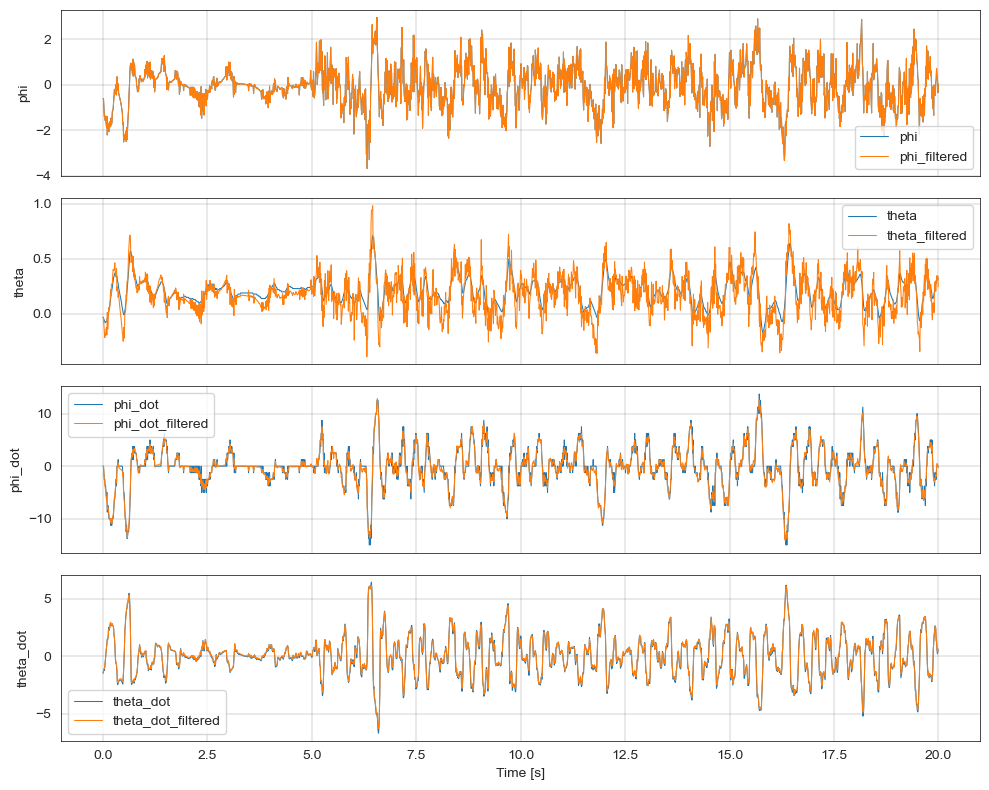

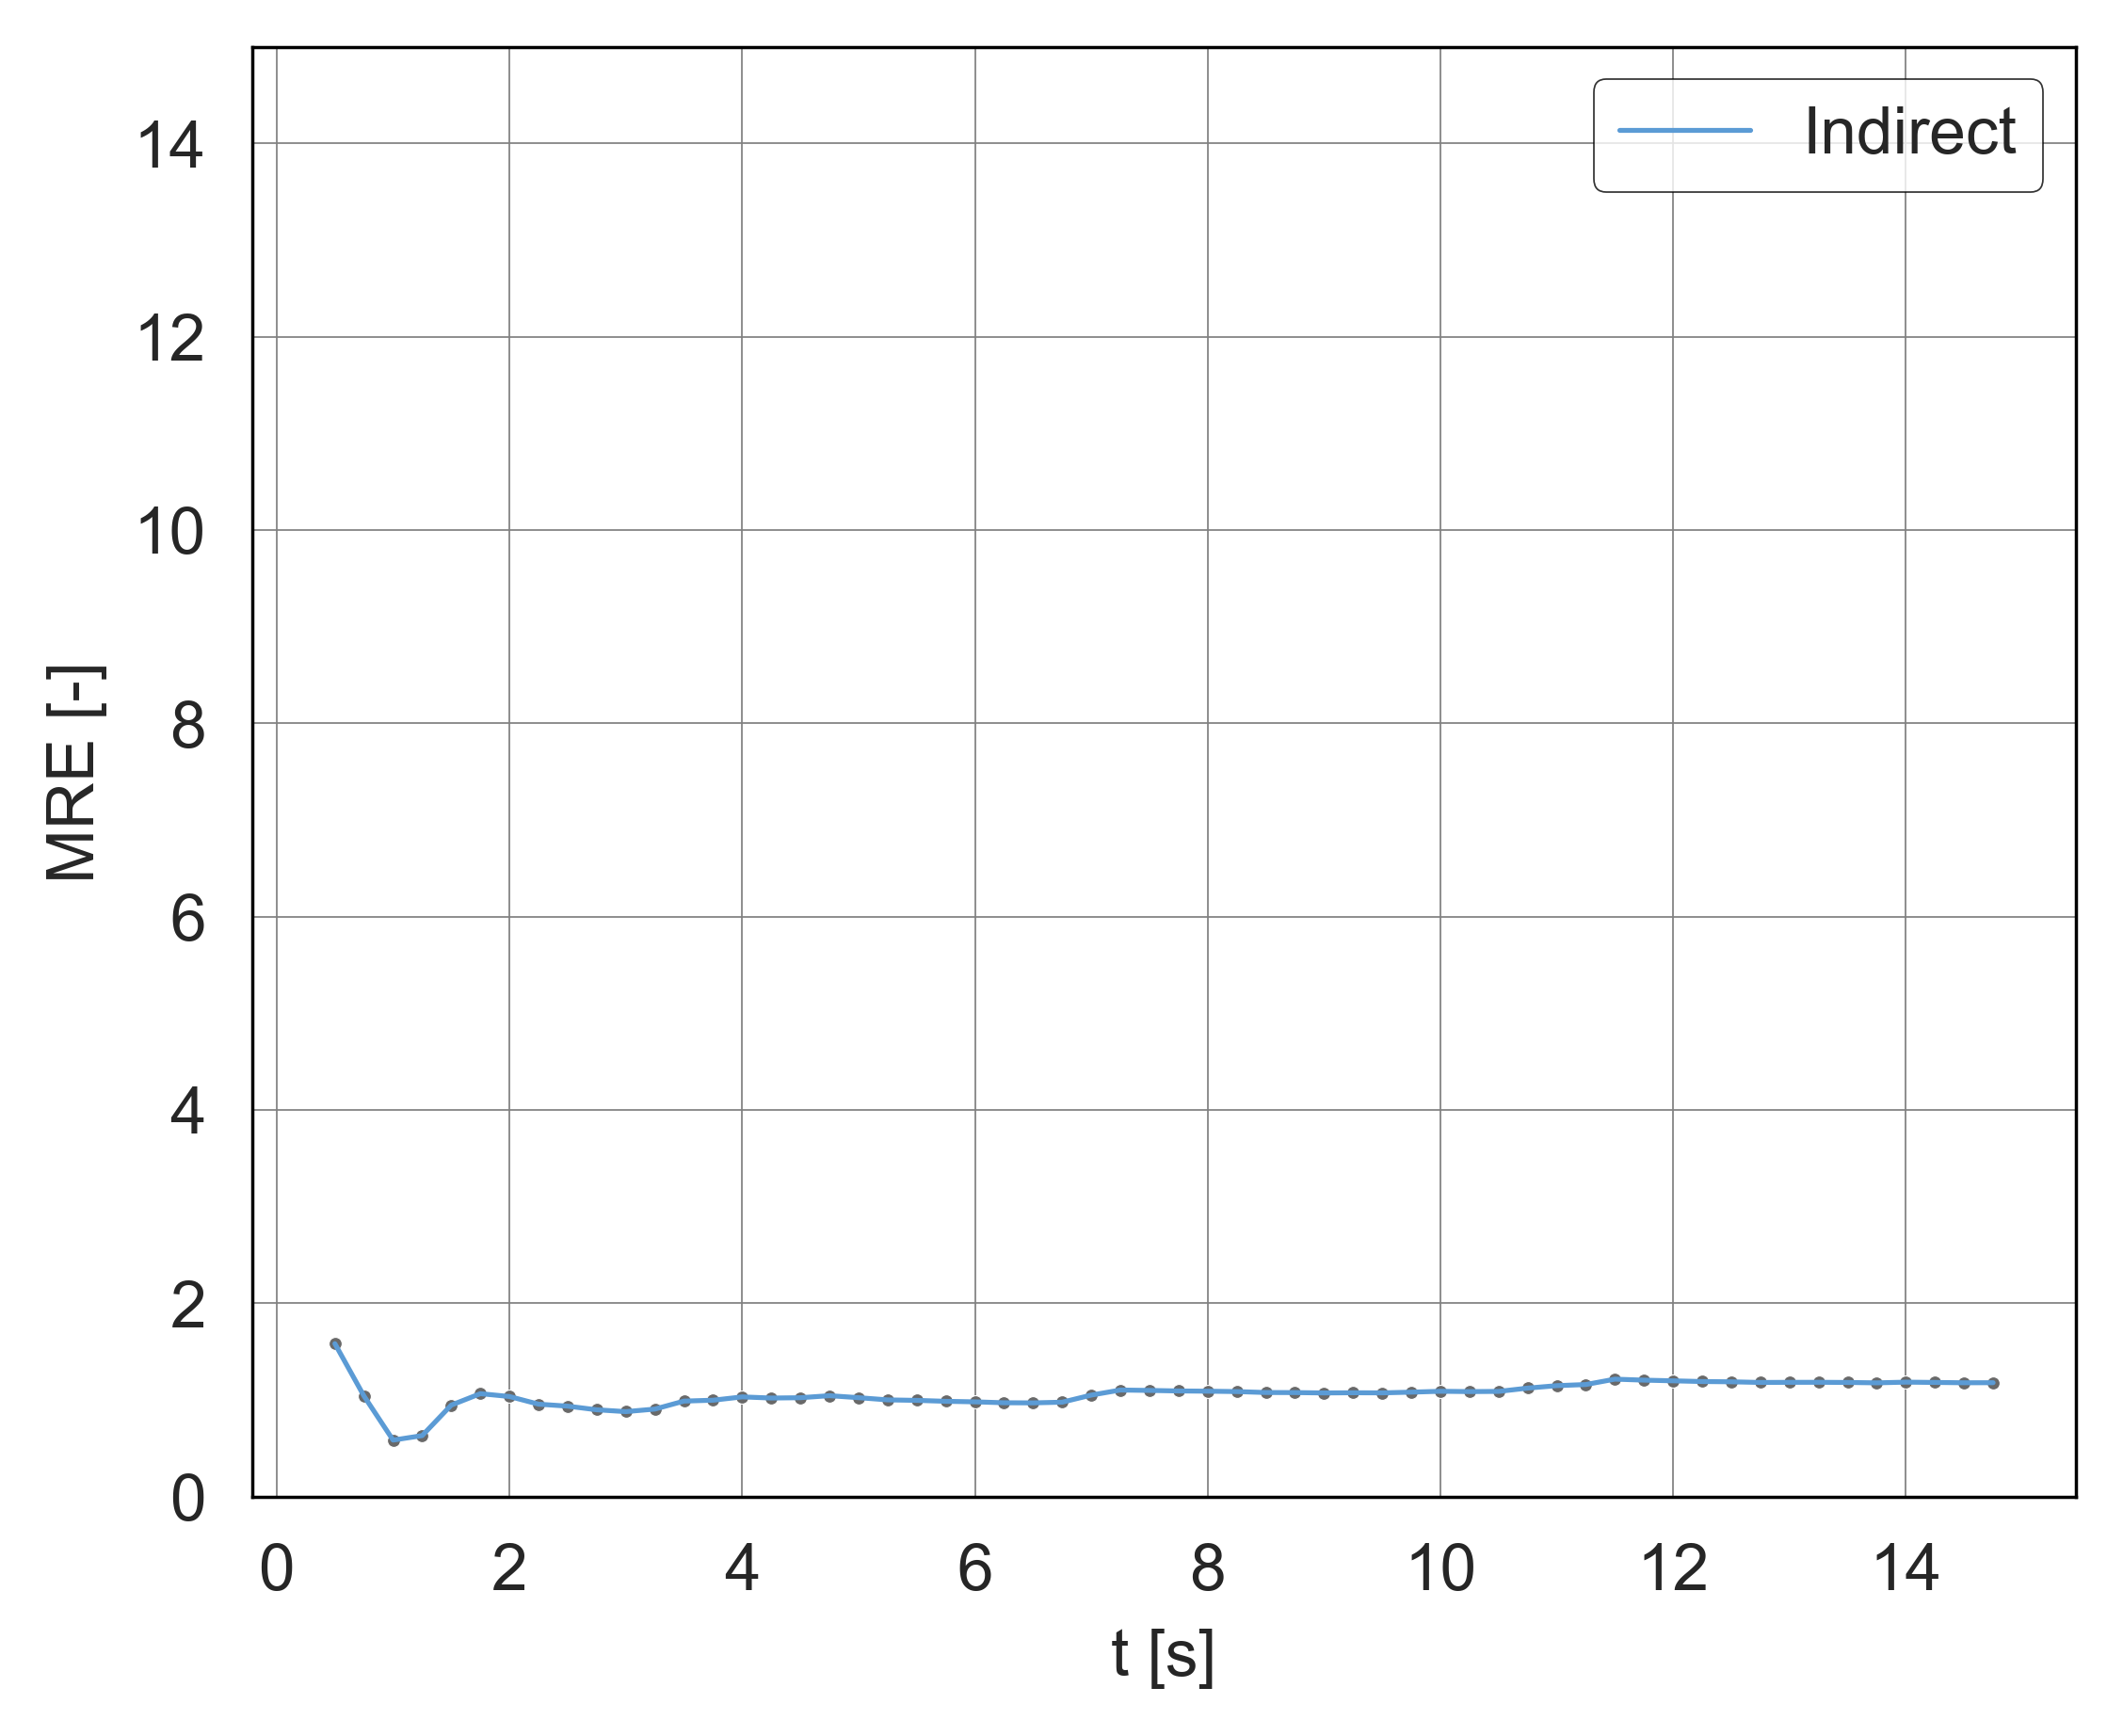

In [9]:
# Define continuous system matrices
A_c = np.array([
    [0, 0, 1, 0], 
    [0, 0, 0, 1], 
    [0, -69.4, 0, 0], 
    [0, 150, 0, 0]
])

B_c = np.array([[0], [0], [273], [-130]])

# Parameters
n = A_c.shape[1]
m = B_c.shape[1]

Ts = 0.01  # Sampling time
# Discretize the system
C = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])  # Output matrix

D = np.array([[0],[0],[0],[0]])
A, B, _,_,_ = cont2discrete((A_c, B_c, C, D), Ts, method='zoh')

# Define the settling time (in seconds)
t_sITAE = 1
t_sBessel = 0.5
itae_4var = (1 / t_sITAE) * np.array([-4.236 + 12.617j, -4.236 - 12.617j, -6.254 + 4.139j, -6.254 - 4.139j])
bessel_4var = (1 / t_sBessel) * np.array([-4.016 + 5.072j, -4.016 - 5.072j, -5.528 + 1.655j, -5.528 - 1.655j])
p_4var_itae = np.exp(itae_4var * Ts)
p_4var_bessel = np.exp(bessel_4var * Ts)

# Model-Based Pole-placement methods
K_itae_theory = ctrl.place(A, B, p_4var_itae)
K_bessel_theory = ctrl.place(A, B, p_4var_bessel)
K_theory = K_bessel_theory - [0,0,0.19,0]

# Arrays to store eigenvalue differences
eig_diff1_values = []
eig_diff2_values = []

Tmin = 500
T_values = np.arange(50, 1500, 25)
np.random.seed(30)

colnames=['time', 'phi', 'theta', 'phi_dot', 'theta_dot', 'ua', 'ref', 'ts'] 

df = pd.read_csv("data/rdmITAE2.txt", names=colnames, header=1)
#df = pd.read_csv("data/Bessel/0.7.txt", names=colnames, header=1)

df.time -= df.time[0]
df = df[df.time<20000]
df.time /=1000
x = np.vstack((df.phi, df.theta, df.phi_dot, df.theta_dot))

# Kalman filter initialization
Q = np.eye(n) * 0.001  # Process noise covariance
R = np.eye(n) * 0.0005  # Measurement noise covariance
P = np.eye(n)  # Initial estimate error covariance
x_hat = np.zeros((n, len(df.time)))  # Estimated states
x_hat[:, 0] = x[:, 0]

#Matrices modification:
a = 7.5
b = 0.19
c = 0.4
A[:,2] = A[:,2]+B.T*(-b)
print("A : {}, B : {}".format(A,B))

# Apply the filters
alpha = 0.5  # Smoothing factor for EMA, can be adjusted

cst = np.sign(df.ua)
df.ua = df.ua - cst*c
ua_filtered = exponential_moving_average(df['ua'], alpha)
ua_filtered = df.ua
# Kalman filter implementation
for k in range(1, len(df.time)):
    # Prediction step
    x_hat[:, k] = A @ x_hat[:, k-1] + B.flatten() * ua_filtered[k-1]
    P = A @ P @ A.T + Q

    # Update step
    K = P @ C.T @ np.linalg.inv(C @ P @ C.T + R)
    x_hat[:, k] = x_hat[:, k] + K @ (x[:, k] - C @ x_hat[:, k])
    P = (np.eye(n) - K @ C) @ P

# Use the filtered signal
x_filtered = x_hat

# Create a new figure with 4 subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

# Plot phi
axs[0].plot(df.time, df.ua, label='phi', linewidth=0.75)
axs[0].plot(df.time, ua_filtered, label='phi_filtered', linewidth=0.75)
axs[0].set_ylabel('phi')
axs[0].legend()

# Plot theta
axs[1].plot(df.time, df.theta, label='theta', linewidth=0.75)
axs[1].plot(df.time, x_filtered[1, :], label='theta_filtered', linewidth=0.75)
axs[1].set_ylabel('theta')
axs[1].legend()

# Plot phi_dot
axs[2].plot(df.time, df.phi_dot, label='phi_dot', linewidth=0.75)
axs[2].plot(df.time, x_filtered[2, :], label='phi_dot_filtered', linewidth=0.75)
axs[2].set_ylabel('phi_dot')
axs[2].legend()

# Plot theta_dot
axs[3].plot(df.time, df.theta_dot, label='theta_dot', linewidth=0.75)
axs[3].plot(df.time, x_filtered[3, :], label='theta_dot_filtered', linewidth=0.75)
axs[3].set_ylabel('theta_dot')
axs[3].legend()

axs[3].set_xlabel('Time [s]')

# Customizing plot borders
for ax in axs:
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)
        spine.set_color('black')

# Setting the style for grid lines
for ax in axs:
    ax.grid(which='major', linestyle='-', linewidth='0.25', color='grey')  # Major grid
    ax.minorticks_on()  # Turn on minor ticks

plt.tight_layout()
plt.savefig("plot/PythonPlotDDIndirectStates.png", bbox_inches='tight')

# Arrays to store eigenvalue differences
eig_diff2_values = []
min_eig_diff2 = np.inf
best_K_indirectDD = []

# Loop over T values
for T in T_values:
    # Feedback gain after perturbation
    U_0 = ua_filtered[Tmin:Tmin+T-1]  # Dimension of U_0 : m x (T-1)
    X_0 = x_filtered[:, Tmin:Tmin+T-1]  # Dimension of X_0 : n x (T-1)
    X_1 = x_filtered[:, Tmin+1:Tmin+T]  # Dimension of X_1 : n x (T-1)

    # Linear Regression for A and B
    BA = np.dot(X_1, np.linalg.pinv(np.vstack([X_0, U_0])))
    A_OL = BA[:, :n]  # This assumes A is in the first n columns of the combined matrix
    B_OL = BA[:, n]   # This assumes B is in the last column of the combined matrix
    if K_theory.all() == K_bessel_theory.all():
        poles = p_4var_bessel
    else:
        poles = p_4var_itae
    K_indirectDD = ctrl.place(A_OL, B_OL.reshape(4,1), poles)
    eig_diff2 = np.mean(np.abs(np.abs(K_indirectDD - K_theory) / -K_theory))
    eig_diff2 = np.mean(np.abs(np.abs(K_indirectDD - K_theory)))
    eig_diff2_values.append(eig_diff2)
    if eig_diff2 < min_eig_diff2:
        min_eig_diff2 = eig_diff2
        best_K_indirectDD = K_indirectDD

print('K_theory:', np.real(K_theory[0]))
print('K_indirectDD with lowest eig_diff2:', best_K_indirectDD[0])
print('Minimum eig_diff2:', min_eig_diff2)

# Plot the eigenvalue differences
plt.figure(figsize=(5, 4), dpi=500)
sns.set_style("whitegrid")

# Plotting the eigenvalue differences
plot_param(T_values / 100,eig_diff2_values , colors[1], 'Indirect')
# Adding labels
plt.xlabel('t [s]')
plt.ylabel('MRE [-]')
plt.ylim(0,15)

# Customizing axes and plot border
ax = plt.gca()  # Get current axis
for spine in ax.spines.values():
    spine.set_linewidth(0.5)
    spine.set_color('black')  # Set spines color to black
    
# Customize legend
legend = plt.legend(frameon=True)
legend_frame = legend.get_frame()
legend_frame.set_edgecolor('black')  # Change the box's border color
legend_frame.set_linewidth(0.25)      # Change the box's border width

# Setting the style for grid lines
plt.grid(which='major', linestyle='-', linewidth='0.25', color='grey')  # Major grid
#plt.grid(which='minor', linestyle=':', linewidth='0.5', color='grey')  # Minor grid
plt.minorticks_on()  # Turn on minor ticks

# Save and show plot
plt.savefig("plot/PythonPlotDDIndirect.png", bbox_inches='tight')  
plt.show()



In [14]:
Ts = 0.05
A, B, _,_,_ = cont2discrete((A_c, B_c, C, D), Ts, method='zoh')
K_itae_theory = ctrl.place(A, B, p_4var_itae)
K_bessel_theory = ctrl.place(A, B, p_4var_bessel)
K_theory = K_bessel_theory[0] - [0,0,0.19,0]
# Print the results in the desired format
print(f'if (ts == 1){{')
print(f'\tK1 = {-K_theory[0]:.3f};')
print(f'\tK2 = {-K_theory[1]:.3f};')
print(f'\tK3 = {-K_theory[2]:.3f};')
print(f'\tK4 = {-K_theory[3]:.3f};')
print('}')

if (ts == 1){
	K1 = 0.001;
	K2 = 1.325;
	K3 = 0.191;
	K4 = 0.080;
}
